In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import re                                               # Libreria per operazioni con le espressioni regolari
import unidecode
import string
import random

import torch
import torch.nn as nn
from torch.autograd import Variable


## Scarichiamo il nostro dataset

In [ ]:
!wget 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

--2023-11-11 10:52:56--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  1.72MB/s    in 0.6s    

2023-11-11 10:52:57 (1.72 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

text = unidecode.unidecode(open("/content/shakespeare.txt", 'rb').read().decode(encoding='utf-8'))
text_len = len(text)
print('text_len =', text_len)


text_len = 1115394


In [ ]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(text))


r I greatly care not:
God knows I had as lief be none as one.

DUKE OF YORK:
Well, bear you well in this new spring of time,
Lest you be cropp'd before you come to prime.
What news from Oxford? hold th


In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))


In [ ]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))


tensor([10, 11, 12, 39, 40, 41])


In [ ]:
def random_training_set(text):
    chunk = random_chunk(text)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target


# Training function

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len


## Evaluation function

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted


In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = GRU(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set(text)
    loss = train(inp, target)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


[(100 5%) 2.4047]
Whing thertere, bempee wines, my thee wis ar; the fom men pald the iste my withe my fere thut ale and  

[(200 10%) 2.1317]
Wher to leat land pald
The enemelaSin your not. Pine goven as
I to your ath ant in dinth tin the misis 

[(300 15%) 1.9932]
Wher and bry anch pigse a fir
He for cawir dailigh of this rith dear shis and is and teree
He and will 

[(400 20%) 2.0463]
Whust reat,
Ris, lonne Her:
He haul wiver I lave thong.

DUES RIO:
Have ion he a fur falvie.

Whatt:
i 

[(500 25%) 1.9277]
Whaning that but bur not my pilene cup to hele
To neir is whe stake thet how theed what,
The there mea 

[(600 30%) 1.9696]
Whive sins.

HAs thinsn I words: be not to wor deman.

LAONTIO:
Ang. Come thy broveing me sheall no, a 

[(700 35%) 1.9017]
What a grome this shought stay.

LeRUMIO:
Kat winlishim to to shood firts's her armberar wht is I him  

[(800 40%) 1.7235]
Whom let,
Roustry, that heak, lort woulder it is as your dess is at the gendusery:

GLOUS:
O, dids, sw 

[(900 45%

# Plotting the loss

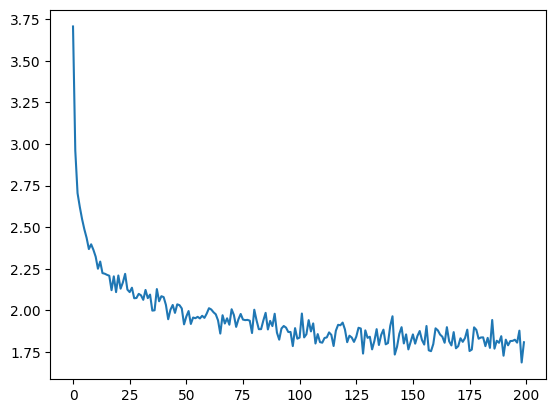

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)


# Evaluating the results

In [ ]:
print(evaluate('Th', 200, temperature=0.8))

Threse the her mine,
And him with that mind that have he surps, thembles in my laught this fain the mone.
Now have in my mence no cousot
hands fill in of then, and my mose and time the low, my such
cent


In [ ]:
print(evaluate('Th', 200, temperature=1.4))

Thy so pail boot, charar outherd.
Serge toglr speing iup you,
Siake, a wou hop offits sweediguon, of by awst thek I.
Than who.
Stinad Yorph; bail Mirson man.

ISABEDUExS:
I to shaveon; ceyocnexto privet


In [ ]:
print(evaluate('Th', 200, temperature=0.2))

The counter him the court with the see well,
So more a where where well the shall the court the king,
And the court the court the son the would my shall he stand
Uncour the court the chall the more wher
